Carga de librerias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

# Datos

Funciones para transformar los datos

In [2]:
import numpy as np

def aplanar(datos, cantidad=10):
  datos = np.split(datos, cantidad)
  return np.array([ejem.flatten(order='C') for ejem in datos])

def des_aplanar(datos, k=7, j=5):
  datos = np.array(datos)
  return np.array([ejem.reshape((k, j), order='C') for ejem in datos])

def binario_a_matriz(datos):
  matrices = []
  for caracter in datos:
    matriz = []
    for byte in caracter:
      fila = [(byte >> i) & 1 for i in range(4, -1, -1)]
      matriz.append(fila)
    matrices.append(matriz)
  return np.array(matrices)

Transformación de los datos

In [3]:
datos = [
    [0x0e, 0x11, 0x17, 0x15, 0x17, 0x10, 0x0f],  # @
    [0x04, 0x0a, 0x11, 0x11, 0x1f, 0x11, 0x11],  # A
    [0x1e, 0x11, 0x11, 0x1e, 0x11, 0x11, 0x1e],  # B
    [0x0e, 0x11, 0x10, 0x10, 0x10, 0x11, 0x0e],  # C
    [0x1e, 0x09, 0x09, 0x09, 0x09, 0x09, 0x1e],  # D
    [0x1f, 0x10, 0x10, 0x1c, 0x10, 0x10, 0x1f],  # E
    [0x1f, 0x10, 0x10, 0x1f, 0x10, 0x10, 0x10],  # F
    [0x0e, 0x11, 0x10, 0x10, 0x13, 0x11, 0x0f],  # G
    [0x11, 0x11, 0x11, 0x1f, 0x11, 0x11, 0x11],  # H
    [0x0e, 0x04, 0x04, 0x04, 0x04, 0x04, 0x0e],  # I
    [0x1f, 0x02, 0x02, 0x02, 0x02, 0x12, 0x0c],  # J
    [0x11, 0x12, 0x14, 0x18, 0x14, 0x12, 0x11],  # K
    [0x10, 0x10, 0x10, 0x10, 0x10, 0x10, 0x1f],  # L
    [0x11, 0x1b, 0x15, 0x11, 0x11, 0x11, 0x11],  # M
    [0x11, 0x11, 0x19, 0x15, 0x13, 0x11, 0x11],  # N
    [0x0e, 0x11, 0x11, 0x11, 0x11, 0x11, 0x0e],  # O
    [0x1e, 0x11, 0x11, 0x1e, 0x10, 0x10, 0x10],  # P
    [0x0e, 0x11, 0x11, 0x11, 0x15, 0x12, 0x0d],  # Q
    [0x1e, 0x11, 0x11, 0x1e, 0x14, 0x12, 0x11],  # R
    [0x0e, 0x11, 0x10, 0x0e, 0x01, 0x11, 0x0e],  # S
    [0x1f, 0x04, 0x04, 0x04, 0x04, 0x04, 0x04],  # T
    [0x11, 0x11, 0x11, 0x11, 0x11, 0x11, 0x0e],  # U
    [0x11, 0x11, 0x11, 0x11, 0x11, 0x0a, 0x04],  # V
    [0x11, 0x11, 0x11, 0x15, 0x15, 0x1b, 0x11],  # W
    [0x11, 0x11, 0x0a, 0x04, 0x0a, 0x11, 0x11],  # X
    [0x11, 0x11, 0x0a, 0x04, 0x04, 0x04, 0x04],  # Y
    [0x1f, 0x01, 0x02, 0x04, 0x08, 0x10, 0x1f],  # Z
    [0x0e, 0x08, 0x08, 0x08, 0x08, 0x08, 0x0e],  # [
    [0x10, 0x10, 0x08, 0x04, 0x02, 0x01, 0x01],  # \
    [0x0e, 0x02, 0x02, 0x02, 0x02, 0x02, 0x0e],  # ]
    [0x04, 0x0a, 0x11, 0x00, 0x00, 0x00, 0x00],  # ^
    [0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x1f],  # _
]

etiquetas = ['@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_']

matrices = binario_a_matriz(datos)

x = aplanar(matrices, len(matrices)) # Datos enchorizados

# Modelos

Funciones auxiliares

In [4]:
def signo(h):
  return 1 if h >= 0 else -1

def g(h, β=1):
  return 1 / (1 + np.exp(-2 * β * h))

def g_derivada(h, β=1):
  return 2 * β * g(h, β) * (1 - g(h, β))

def binary_crossentropy(y, ypred):
  ε = 1e-8  # evitar log(0)
  return -np.mean(y * np.log(ypred + ε) + (1 - y) * np.log(1 - ypred + ε))

def MSE(y, ypred):
  return 1/2 * np.sum((y - ypred)**2)

Modelo autoencoder

In [5]:
def autoencoder(x, y, η, epocas):
  np.random.seed(11)

  # Cantidad de neuronas
  entrada = salida = int(x.shape[1]) # Igual que salida
  oculta1 = oculta2 = 20 # Ambas del mismo tamaño
  latente = 2

  # Creo mis pesos
  w1 = np.random.normal(0, 0.1, (entrada, oculta1))
  w2 = np.random.normal(0, 0.1, (oculta1, latente))
  w3 = np.random.normal(0, 0.1, (latente, oculta2))
  w4 = np.random.normal(0, 0.1, (oculta2, salida))

  # Creo mis sesgos
  b1 = np.zeros((1, oculta1))
  b2 = np.zeros((1, latente))
  b3 = np.zeros((1, oculta2))
  b4 = np.zeros((1, salida))

  error = np.inf
  error_min = np.inf
  errores = []

  for _ in range(epocas):
    indices = np.random.permutation(x.shape[0])

    for indice in indices:
      Vk = x[indice].reshape(1, -1)
      yk = y[indice].reshape(1, -1)

      # Propagar
      h1 = Vk @ w1 + b1
      V1 = g(h1)

      h2 = V1 @ w2 + b2
      V2 = g(h2)

      h3 = V2 @ w3 + b3
      V3 = g(h3)

      h4 = V3 @ w4 + b4
      V4 = g(h4)

      # Retropropagar
      δ4 = g_derivada(h4) * (yk - V4)
      δ3 = g_derivada(h3) * (δ4 @ w4.T)
      δ2 = g_derivada(h2) * (δ3 @ w3.T)
      δ1 = g_derivada(h1) * (δ2 @ w2.T)

      # Actualización de pesos y sesgos
      w4 += η * (V3.T @ δ4)
      b4 += η * δ4

      w3 += η * (V2.T @ δ3)
      b3 += η * δ3

      w2 += η * (V1.T @ δ2)
      b2 += η * δ2

      w1 += η * (Vk.T @ δ1)
      b1 += η * δ1

      #Calculo de error
      error = binary_crossentropy(yk, V4)

      if error < error_min:
        error_min = error
        w1_min, w2_min, w3_min, w4_min = w1.copy(), w2.copy(), w3.copy(), w4.copy()
        b1_min, b2_min, b3_min, b4_min = b1.copy(), b2.copy(), b3.copy(), b4.copy()

    errores.append(error_min)

  print(f"Entrenamiento realizado con {epocas} epocas y error mínimo alcanzado: {error_min}")
  plt.plot(errores)
  plt.title("Error por época")
  plt.xlabel("Época")
  plt.ylabel("Error")
  plt.grid()
  plt.show()
  return w1_min, w2_min, w3_min, w4_min, b1_min, b2_min, b3_min, b4_min

def predecir_autoencoder(Vk, w1, w2, w3, w4, b1, b2, b3, b4):
  V1 = g(Vk @ w1 + b1)
  V2 = g(V1 @ w2 + b2)
  V3 = g(V2 @ w3 + b3)
  V4 = g(V3 @ w4 + b4)
  return V4

Encoder y decoder

In [6]:
def encoder(Vk, w1, w2, b1, b2):
  V1 = g(Vk @ w1 + b1)
  V2 = g(V1 @ w2 + b2)
  return V2

def decoder(V_latente, w3, w4, b3, b4):
  V3 = g(V_latente @ w3 + b3)
  V4 = g(V3 @ w4 + b4)
  return V4

# Pruebas autoencoder

Prueba autoencoder

Entrenamiento realizado con 3000 epocas y error mínimo alcanzado: 0.01736085440160021


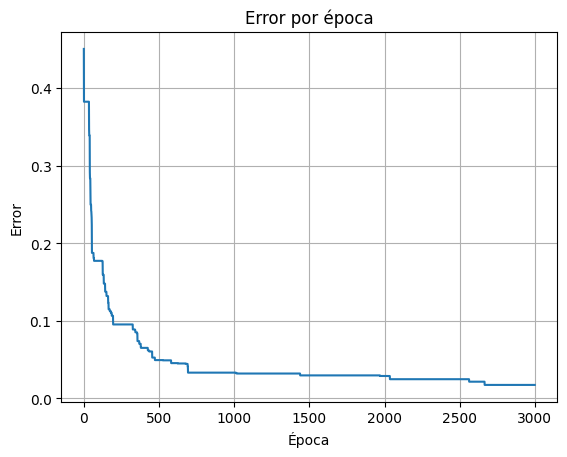

In [7]:
w1, w2, w3, w4, b1, b2, b3, b4 = autoencoder(x, x, 0.1, 3000)

Predicciones

In [8]:
ypred = predecir_autoencoder(x, w1, w2, w3, w4, b1, b2, b3, b4)
reconstruccion = np.round(ypred).astype(int)
#ypred = des_aplanar(ypred, 5, 7)
print(reconstruccion[1])
print(x[1])

[1 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 1 1 0 0 0 1]
[0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 1 1 0 0 0 1]


In [9]:
matriz_nueva = des_aplanar(reconstruccion, 7, 5)
matriz_nueva[1]

array([[1, 0, 0, 0, 0],
       [1, 1, 0, 1, 0],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [1, 1, 1, 1, 1],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1]])

# Pruebas Encoder

Función para graficar capa latente

In [10]:
def graficar_capa_latente(codificados, etiquetas, fontsize=12, fcolor='black'):
  plt.figure(figsize=(10,8))
  plt.scatter(codificados[:,0], codificados[:,1], color='white')

  for i, etiqueta in enumerate(etiquetas):
      x1, y1 = codificados[i, 0], codificados[i, 1]
      texto = plt.text(x1, y1, etiqueta, fontsize=fontsize, ha='center', va='center', color='white')
      texto.set_path_effects([
          path_effects.Stroke(linewidth=(int(fontsize/8)), foreground=fcolor),  # contorno negro
          path_effects.Normal()  # texto original encima
      ])

  #plt.title('Representaciones latentes con contorno en las etiquetas')
  # Si se usa referencia el gráfico no debe tener titulo
  plt.grid(True)
  plt.xlim(-0.05, 1.05)
  plt.ylim(-0.05, 1.05)
  plt.show()

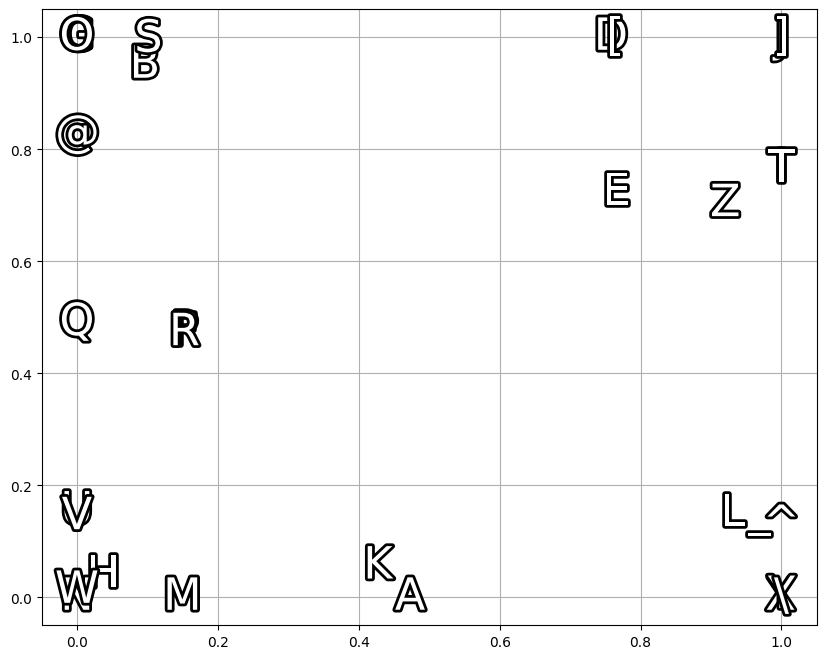

In [11]:
codificados1 = encoder(x, w1, w2, b1, b2)

graficar_capa_latente(codificados1, etiquetas, 32)